# Real or Not? NLP with Twitter
*Author: Tucker Arrants*


**In this notebook, we will explore natural language processing (NLP) by analyzing 10,000 hand classified tweets. These tweets have been labelled as those about disasters, and those not. Consider two hypothetical tweets:**

> That concert last night was FIRE!  
> There's a huge fire in Malibu right now!!!

**Both of these tweets invoke the notion of 'fire' but only the second is about a real disaster. Can we train a model to distinguish between the two?**

**If we can, then such a model could be used to provide a framework for disaster detection through social media**

**First we will visualize and analyze the data; then we will process the text from the tweets and embed the words in a pre-trained dictionary (corpus); and lastly, we will feed this information to a neural network to predict binary classification **

In [1]:
%matplotlib inline
#manipulation
import numpy as np
import pandas as pd

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
import string
import re
from nltk.corpus import stopwords

#stemming/lemmatizing/vectorizing
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

#processing
from sklearn.model_selection import train_test_split

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

#for relative file path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [2]:
print(os.listdir("../input"))

['nlp-getting-started', 'glove-global-vectors-for-word-representation']


# I. Exploration

In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**We see that we have three features in this dataset: keyword, location, and text**

**Let us now save the ID column later for our submission and combine data sets into a single DataFrame:**

**Note: we will not be using keyword or location seeing as they are missing a lot of values and are not likely to improve the accuracy of our deep learning model**

In [4]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'keyword', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)

#change target to target1 in preparation for the word 'target' to be encoded as its own column
total = total.rename(columns = {'target':'target1'})

In [5]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


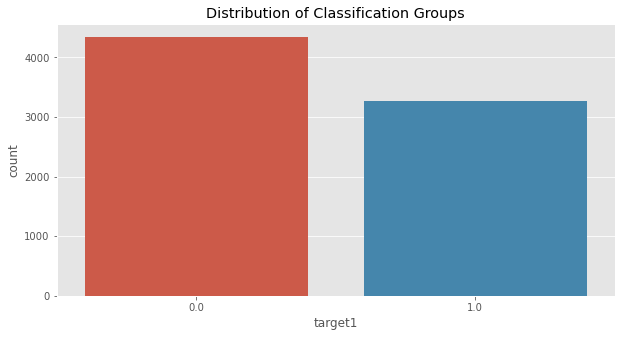

In [6]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target1', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

**So we have more tweets in class 0 (not a disaster tweet) than class 1 (disaster tweet)**

## Adding basic features

**We can easily add some new features to help us explore the attributes of tweets that are about disasters**

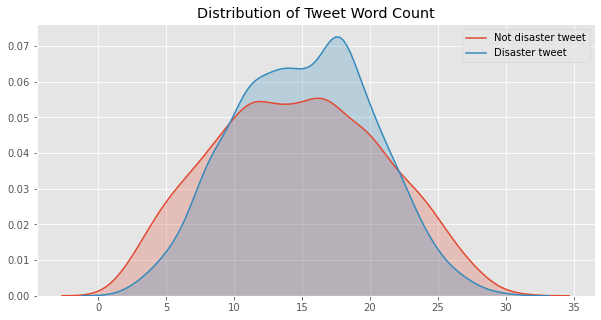

In [7]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target1'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['word count'][train['target1'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

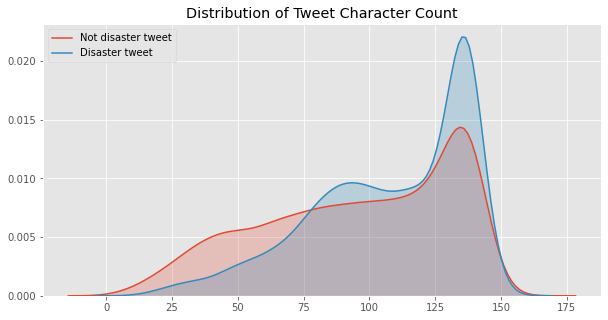

In [8]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target1'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['character count'][train['target1'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()

**This is insightful as it tells us that very few disaster tweets are less than 50 characters and that the majority of them are more than 125 characters long**

### Average Word Length

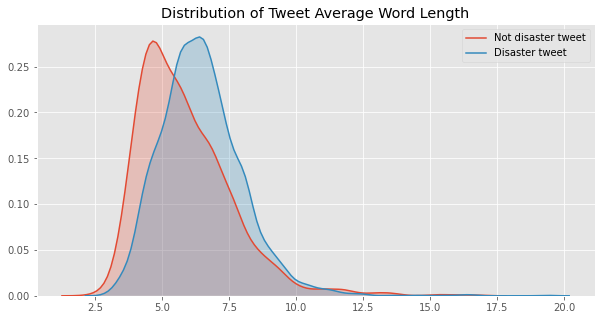

In [9]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target1'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['average word length'][train['target1'] == 1], shade = True, label = 'Disaster tweet')

#set title
plt.title('Distribution of Tweet Average Word Length')

#splot graphs
plt.show()

**Now that we have an idea of what new features to construct and how they might be useful, let's add the rest of them and visualize them:**

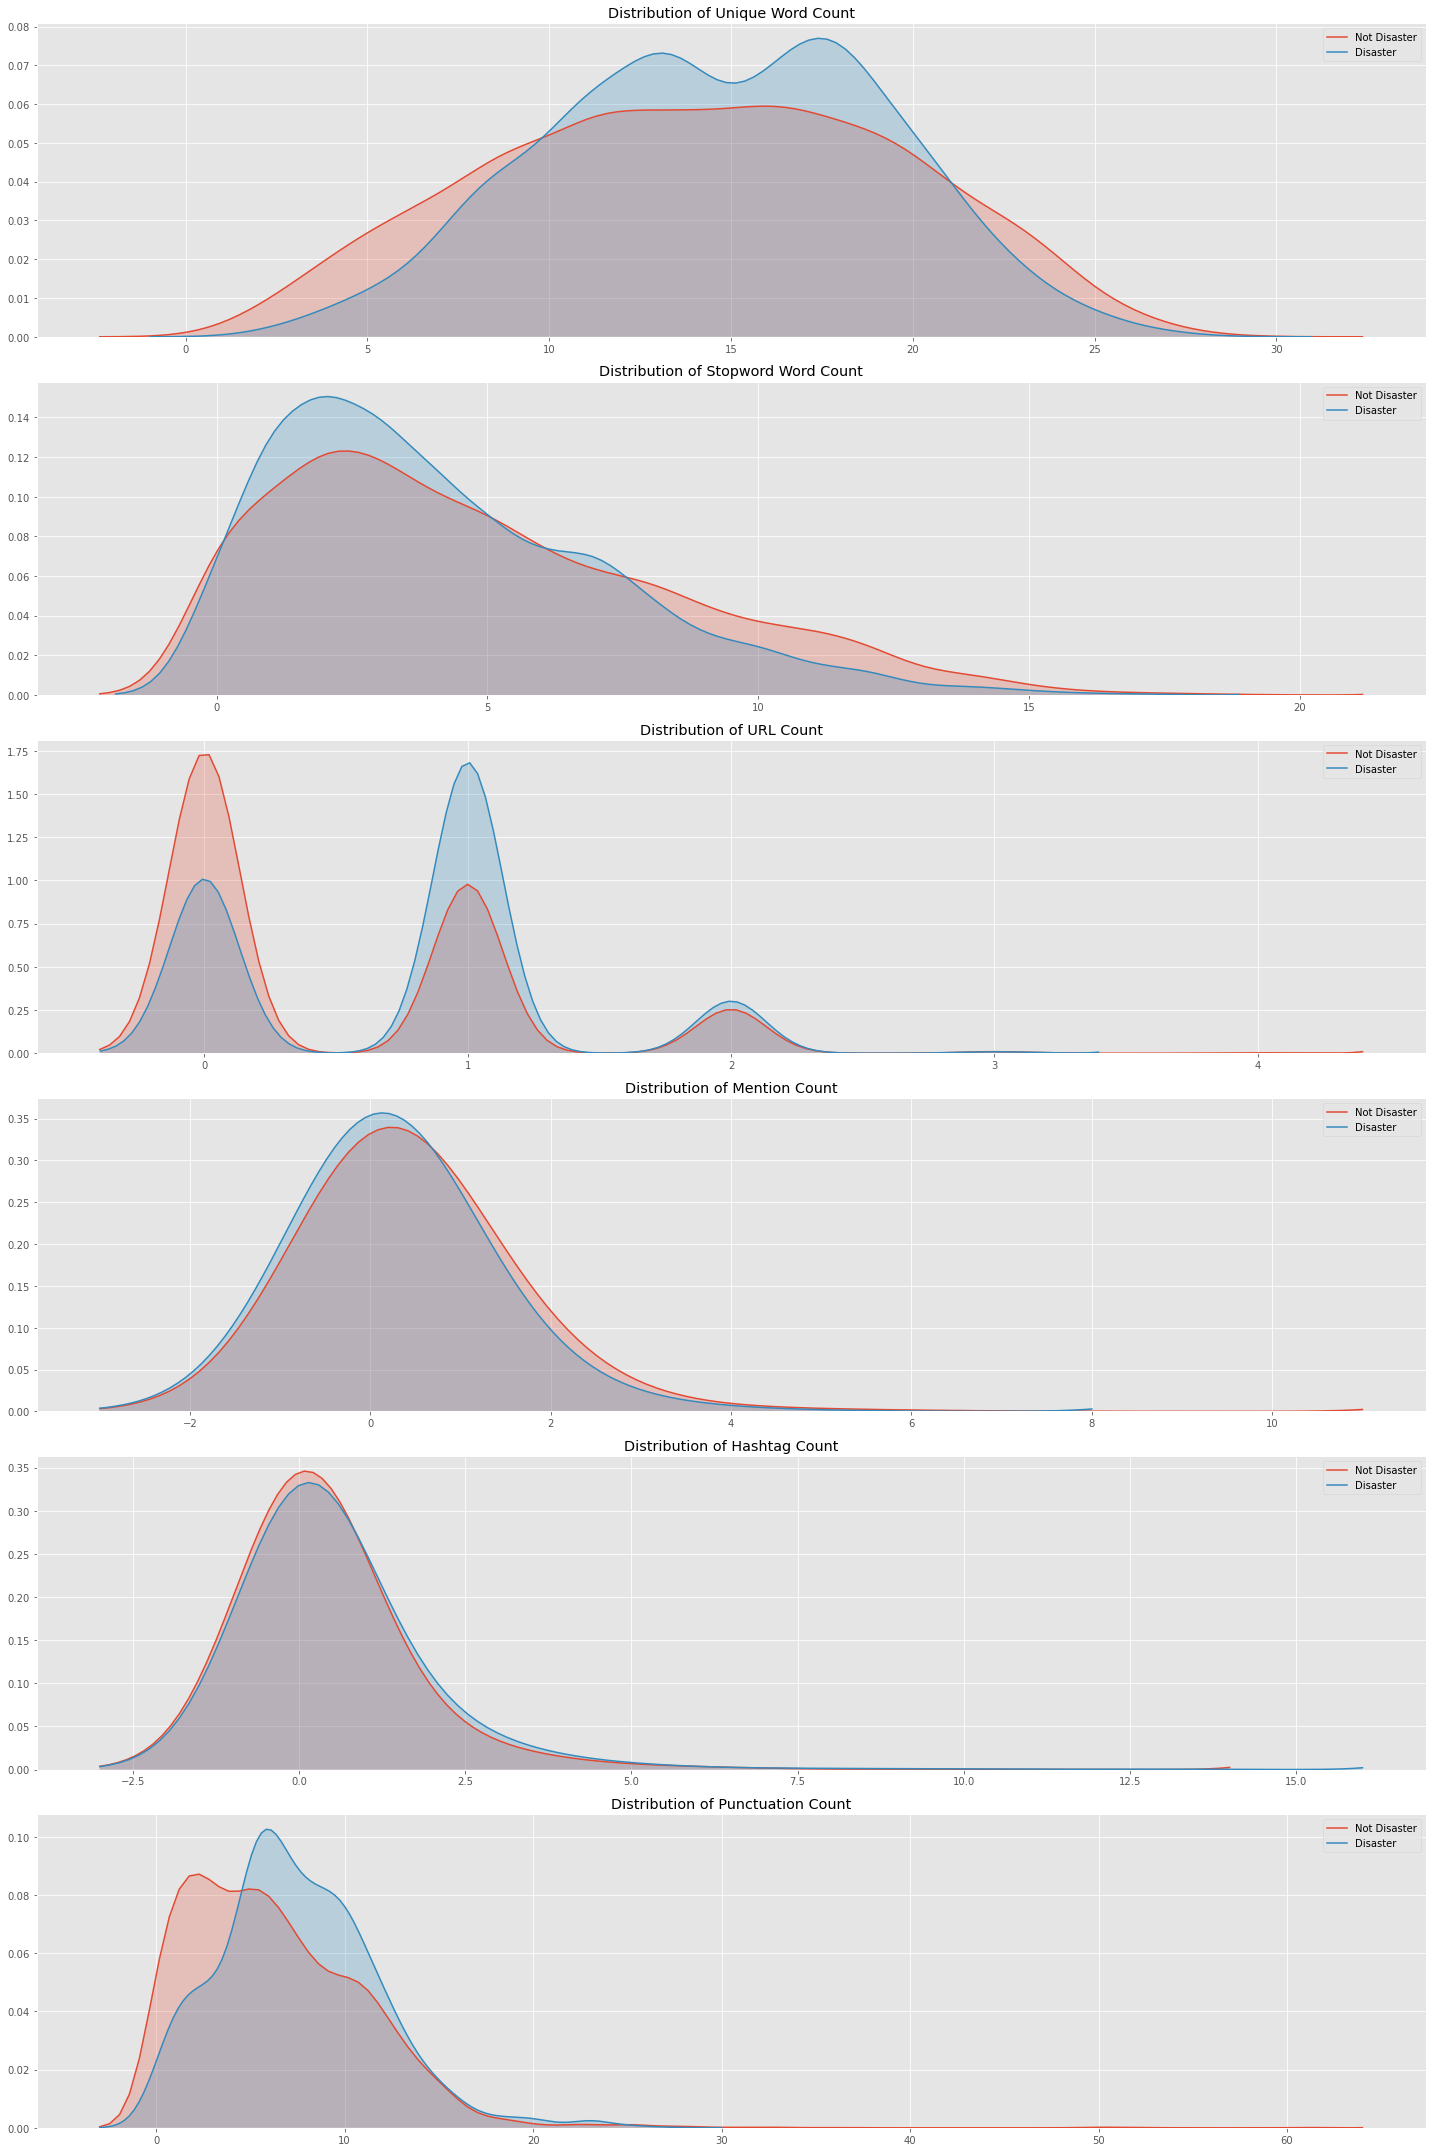

In [10]:
#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
stopwords = stopwords.words('english')
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in stopwords]))

#add url count
total['url count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
total['mention count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
total['hashtag count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train = total[:len(train)]

disaster = train['target1'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(6, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train.loc[~disaster]['url count'], shade = True, label = 'Not Disaster', ax=axes[2])
graph3 = sns.kdeplot(train.loc[disaster]['url count'], shade = True, label = 'Disaster', ax=axes[2])
graph3.set_title('Distribution of URL Count')

graph4 = sns.kdeplot(train.loc[~disaster]['mention count'], shade = True,  label = 'Not Disaster', ax=axes[3], bw = 1)
graph4 = sns.kdeplot(train.loc[disaster]['mention count'], shade = True, label = 'Disaster', ax=axes[3], bw =1)
graph4.set_title('Distribution of Mention Count')

graph5 = sns.kdeplot(train.loc[~disaster]['hashtag count'], shade = True, label = 'Not Disaster', ax=axes[4], bw = 1)
graph5 = sns.kdeplot(train.loc[disaster]['hashtag count'], shade = True, label = 'Disaster', ax=axes[4], bw = 1)
graph5.set_title('Distribution of Hashtag Count')

graph6 = sns.kdeplot(train.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[5], bw = 1)
graph6 = sns.kdeplot(train.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[5], bw = 1)
graph6.set_title('Distribution of Punctuation Count')

fig.tight_layout()
plt.show()

# II. Cleaning

**Now that we have explored our data, we need to prepare it for machine learning. In general, to process text we need to apply the following procedure:** 

> raw text corpus -> processing text -> tokenized text -> corpus vocabulary -> text representation 

**We can do most of the hard work with Keras's Tokenize object, which automatically converts all words to lowercase and filters out punctuation**  

**So, we will not be performing any data cleansing other than what is provided by default with Kera's Tokenizer, but I will leave the code below that manually cleans text data for reference:**

In [11]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
StopWords = stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in StopWords])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha() == True])

#stem words
stemmer = SnowballStemmer('english')
def stem_words(x):
    return stemmer.stem(x)

#lemmatize words for verb
lemmatizer = WordNetLemmatizer()
def lemmatize_words_verb(x):
    return lemmatizer.lemmatize(x, 'v')

#lemmatize words for verb
lemmatizer = WordNetLemmatizer()
def lemmatize_words_noun(x):
    return lemmatizer.lemmatize(x, 'n')


In [12]:
#make lowercase
#total['text'] = total['text'].apply(lambda x: x.lower())

#remove url
#total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))

#apply all of above functions
#total['text'] = total['text'].apply(remove_punctuation)
#total['text'] = total['text'].apply(remove_stopwords)
#total['text'] = total['text'].apply(remove_less_than)
#total['text'] = total['text'].apply(remove_non_alphabet)
#total['text'] = total['text'].apply(stem_words)
#total['text'] = total['text'].apply(lemmatize_words_noun)
#total['text'] = total['text'].apply(lemmatize_words_verb)

# III. Deep Learning With Keras

**https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html**

**Instead of following the Bag of Word approach, were we one hot encode all the words in our vocabulary, we will simply import the pre-trained words from GloVe:**  

> "GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."

**For example, we can take the vector for King and subtract the vector for Man and the resulting vector is remarkably close to the vector for Queen. Using these word encodings as opposed to the Bag of Word encodings will substantially improve our classification accuracy. This is because Bag of Word encodings cannot capture meaning: sentences with the same words are identically encoded and hence phrases like**

> Woman, without her man, is helpless.  
> Woman! Without her, man is helpless!


**are encoded to mean the same (and they certainly don't!)**

## 1. Embedding 

In [13]:
texts = [tweet for tweet in total['text']]

#pre define parameters
MAX_NB_WORDS = 100
MAX_SEQUENCE_LENGTH = 33 
EMBEDDING_DIM = 100

#split data
train = total[:len(train)]
test = total[len(train):]

In [14]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#set random seeds for reproducability 
np.random.seed(34)
tf.random.set_seed(34)

tokenizer = Tokenizer()   #nb_words=MAX_NB_WORDS
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = train['target1']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

X_train = data[:len(train)]
y_train = labels
X_test = data[len(train):]

Using TensorFlow backend.


Found 29319 unique tokens.
Shape of data tensor: (10876, 33)
Shape of label tensor: (7613,)


**We will be using the 100D vectors of GloVe which means that each word in the vocabulary is embedded in a 100 by 1 vector**

In [15]:
#get GloVe vector embeddings
embeddings_index = {}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:22, 17572.11it/s]

Found 400000 word vectors in the GloVe library


In [16]:
#embed our vocab with the GloVe pretrained vocab
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 29319/29319 [00:00<00:00, 278941.60it/s]


In [17]:
print("Our embedded matrix is of dimension", embedding_matrix.shape)

Our embedded matrix is of dimension (29320, 100)


In [18]:
meta_input_train = train.iloc[:, 2:]
meta_input_test = test.iloc[:, 2:]

In [19]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate
from keras import Input, Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1,
                        EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False)            #we do not want embedding layer to train since it has been pretrained

In [20]:
def create_lstm(spatial_dropout, dropout, recurrent_dropout):
    model = Sequential()
    model.add(embedding)
    model.add(SpatialDropout1D(spatial_dropout))
    model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout = dropout, recurrent_dropout = recurrent_dropout)))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = Adam(learning_rate = 3e-4)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [21]:
def create_lstm2(spatial_dropout, dropout, recurrent_dropout):
    
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (9, ), name = 'meta_input_train')
    emb = embedding(nlp_input)
    nlp_out = (Bidirectional(LSTM(EMBEDDING_DIM, dropout = dropout, recurrent_dropout = recurrent_dropout)))(emb)
    x = Concatenate()([nlp_out, meta_input_train])
    preds = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = 3e-4)
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

**The two parameters we must specify to train our LSTM model are the batch size and the epoch**  

**Batch size is simply the number of samples that are propograted through our network and the epoch is just an arbitrary cutoff, generally defined as "one pass over the entire dataset"**

**We will begin with a lower batch size and train for longer than necessary so that we can view the models learning curves. We can actually tune our batch size instead of learning rate if our model is taking too long to train, which is explained in this article:**

> https://arxiv.org/pdf/1711.00489.pdf

**There is a sweet spot for the batch size that lies somewhere between 1 and the number of samples in your data set. In general, the default batch size of 32 works well**

In [22]:
def plot_learning_curves(history):
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [23]:
#define dropout rates
spatial_dropout = .5
dropout = .3
recurrent_dropout = .2

model1 = create_lstm2(spatial_dropout, dropout, recurrent_dropout)

**We can implement a callback that automatically halts model training as soon as the validation loss starts to increase. This can also serve as a layman's grid search for epochs, seeing as we will be able to see at which epoch our model is optimized**  

In [24]:
callback = EarlyStopping(monitor = 'val_loss', patience = 5)

**We are interested in the val_accuracy and val_loss. To prevent overfitting, we select val_loss as our monitoring parameter**

**The patience arguement is just the number of epochs before stopping once our monitoring parameter stops improving**

**If we use a smaller batch size (or a larger learning rate), our val_loss will be more noisy (zig-zag more) so we need to set a larger patience arguement to ensure our model does not prematurely end it's training**

In [25]:
#fit model
history1 = model1.fit([X_train, meta_input], y_train, validation_split = .2,
         epochs = 50, batch_size = 16, verbose = 1, callbacks = [callback])

NameError: name 'meta_input' is not defined

In [26]:
plot_learning_curves(history1)

NameError: name 'history1' is not defined

### Different Dropout Rates

**Dropout layers can help reduce overfitting, but there is no obvious way to add them and where to add them, so we will just have to experiment a bit**

**For the curious reader, the article below is very informative:**

> https://arxiv.org/pdf/1512.05287.pdf

# IV. Submission

**Let us now choose a model to predict on our test set**  

**Since the leaderboard scores for this competition are based on the f1 score, we will look at a classification report for each of our models to choose our final model**

## Classification Report

**We will check the precision, recall, and f-1 score as a final metric**

In [27]:
#from sklearn.metrics import classification_report

#y_true = y_train
#y_pred = model1.predict([X_train, meta_input_train])

#target_names = ['Not Disaster', 'Disaster']
#print('Classification report for model1')
#print(classification_report(y_true, y_pred, target_names=target_names))

In [28]:
submission = pd.DataFrame()
submission['id'] = test_id
submission['prob'] = model1.predict([X_test, meta_input_test])
submission['target'] = submission['prob'].apply(lambda x: 0 if x < .5 else 1)
submission.head(10)

,id,prob,target
0,0,0.165131,0
1,2,0.039152,0
2,3,0.007738,0
3,9,0.149522,0
4,11,0.098024,0
5,12,0.154345,0
6,21,0.031252,0
7,22,0.338808,0
8,27,0.373220,0
9,29,0.472645,0


In [29]:
#save final predictions to a csv file
submission.to_csv('submission.csv', index=False)
print("Submission has been saved")

Submission has been saved


In [30]:
test.head(10)

,text,target1,word count,character count,average word length,unique word count,stopword count,url count,mention count,hashtag count,punctuation count
0,Just happened a terrible car crash,NaN,6,34,4.833333,6,2,0,0,0,0
1,"Heard about #earthquake is different cities, s...",NaN,9,64,6.222222,9,2,0,0,1,3
2,"there is a forest fire at spot pond, geese are...",NaN,19,96,4.105263,19,9,0,0,0,2
3,Apocalypse lighting. #Spokane #wildfires,NaN,4,40,9.250000,4,0,0,0,2,3
4,Typhoon Soudelor kills 28 in China and Taiwan,NaN,8,45,4.750000,8,2,0,0,0,0
5,We're shaking...It's an earthquake,NaN,4,34,7.750000,4,1,0,0,0,5
6,They'd probably still show more life than Arse...,NaN,12,72,5.083333,12,3,0,0,0,4
7,Hey! How are you?,NaN,4,17,3.500000,4,2,0,0,0,2
8,What a nice hat?,NaN,4,16,3.250000,4,2,0,0,0,1
9,Fuck off!,NaN,2,9,4.000000,2,0,0,0,0,1
